In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import json
import re
import time
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

# Vivino ratings

In [3]:
# this is a processing of the original file found on
# the Colorado index of Complex Networks (https://icon.colorado.edu/networks). 

In [4]:
def process_file(filename):
    df_vivino=pd.read_json(filename, lines=True)
    x=df_vivino['taste_profile'].iloc[0]
    #ratings=re.findall(r"\{.*?\}", x)
    #row_df=pd.json_normalize(json.loads(ratings[0].replace("'",'"')))
    i=0
    t = time.time()
    for index, row in df_vivino.iterrows():
        

        ratings=re.findall(r"\{.*?\}", row['taste_profile'])
        for rating in ratings:
            rating.replace("'",'"')
            row=pd.json_normalize(json.loads(rating.replace("'",'"')))
            row['user_id']=int(df_vivino['id'].iloc[i][5:])
            row['user_country']=(df_vivino['country'].iloc[i])
            row['average_rating']=float(row['average_rating'])
            row['number_ratings']=float(row['number_ratings'])
            row['wine_region']=(row['wine_region'])
            #print(row)
            row = row[['user_id','user_country','wine_region','regional_style','average_rating','number_ratings']]
            row.to_csv('vivino_regional_styles.csv', mode='a', index=False, header=False)
            #row_df=pd.concat([row_df, row])
        i=i+1
        if i%1000==0: 
            elapsed = time.time() - t
            print(i,elapsed)
            t = time.time()
        else:
            continue

In [5]:
#process_file('vivino_user_taste_profiles.json')

# load Colorado dataset

In [6]:
colnames=['user_id', 'user_country','wine_region', 'regional_style', 'average_rating','number_ratings'] 
row_df = pd.read_csv('vivino_regional_styles.csv', names=colnames, header=None)
row_df['number_ratings']=row_df['number_ratings'].astype(int)
row_df['user']=row_df['user_id']
row_df['item']=row_df['regional_style'].str.replace('/wine-styles/','')
row_df['rating']=row_df['average_rating']
row_df['item_country']=row_df['wine_region']

In [7]:
row_df.head()

,user_id,user_country,wine_region,regional_style,average_rating,number_ratings,user,item,rating,item_country
0,2,Australia,Spain,/wine-styles/spanish-grenache,2.0,1,2,spanish-grenache,2.0,Spain
1,2,Australia,Australia,/wine-styles/australian-pinot-noir,4.0,1,2,australian-pinot-noir,4.0,Australia
2,2,Australia,Chile,/wine-styles/chilean-pinot-noir,1.0,1,2,chilean-pinot-noir,1.0,Chile
3,2,Australia,Germany,/wine-styles/german-spatburgunder,3.0,1,2,german-spatburgunder,3.0,Germany
4,2,Australia,New Zealand,/wine-styles/new-zealand-pinot-noir,4.0,1,2,new-zealand-pinot-noir,4.0,New Zealand


In [8]:
len(row_df)

2596567

In [9]:
len(row_df.groupby('user_id'))

129351

In [10]:
def get_user_df(df):
    df['prod']=df['rating']*df['number_ratings']
    all_users_counts=df[['user','rating']].groupby('user').count().rename(columns={'rating': 'count'})
    all_users_means=df[['user','rating']].groupby('user').mean()
    all_sums=df[['user','rating','number_ratings','prod']].groupby('user').sum()
    all_users_means['weighted_rating']=all_sums['prod']/all_sums['number_ratings']
    all_users_experience=df[['user','number_ratings']].groupby('user').sum().rename(columns={'number_ratings': 'exp'})
    all_users_stds=df[['user','rating']].groupby('user').std().rename(columns={'rating': 'std'})
    all_users_skews=df[['user','rating']].groupby('user').skew().rename(columns={'rating': 'skew'})
    df_users=pd.concat((all_users_counts['count'],all_users_experience['exp'],all_users_means['rating'],all_users_means['weighted_rating'],all_users_stds['std'],all_users_skews['skew']),axis=1).rename(columns={'item': 'count', 'rating': 'pikiness', 'weighted_rating': 'weighted_pikiness'})
    return df_users

def get_item_df(df):
    df['prod']=df['rating']*df['number_ratings']
    df['pikiness_prod']=df['weighted_pikiness']*df['number_ratings']
    all_counts=df[['item','rating']].groupby('item').count().rename(columns={'rating': 'count'})
    all_means=df[['item','rating','pikiness']].groupby('item').mean()  
    all_sums=df[['item','rating','number_ratings','prod','pikiness_prod']].groupby('item').sum()
    all_sums['weighted_rating']=all_sums['prod']/all_sums['number_ratings']
    all_sums['normalized_weighted_rating']=all_sums['prod']/all_sums['number_ratings']-all_sums['pikiness_prod']/all_sums['number_ratings']
    df_items=pd.concat((all_counts['count'],all_means['rating'],all_sums['weighted_rating'],all_sums['normalized_weighted_rating']),axis=1).rename(columns={'count': 'item_rating_count', 'rating': 'item_rating_avg'})
    return df_items

In [11]:
def train_test_split(df,train_pct):
    #df=row_df[row_df['number_ratings']>=wines_per_region_per_person][['user','item','rating','user_country','number_ratings']]
    df_users=get_user_df(df)
    df_with_users = df.merge(df_users, 
               how = 'inner',
               left_on = 'user',
               right_on = 'user')
    df_items=get_item_df(df_with_users)
    df = df_with_users.merge(df_items, 
               how = 'inner',
               left_on = 'item',
               right_on = 'item')
    
    split_point=int(round(len(df)*train_pct/100,0))
    df = df.sample(frac = 1)
    df_train=df.iloc[:split_point]
    df_test=df.iloc[split_point:]
    
    return df_train,df_test,df

In [12]:
regions_per_user_threshold=1
wines_per_region_per_person=1
train_pct=50

In [13]:
df_train,df_test,df=train_test_split(row_df,train_pct)

In [14]:
print(len(df_train),len(df_test))

1298284 1298283


In [15]:
df_users=get_user_df(df)

In [16]:
df_users.head()

,count,exp,pikiness,weighted_pikiness,std,skew
user,,,,,,
2,6,6,3.000000,3.000000,1.264911,-0.889391
4,42,121,3.876190,3.966942,0.575860,-0.795567
6,8,10,3.412500,3.360000,0.538351,-0.531163
9,6,7,3.633333,3.585714,0.432049,-0.541439
30,107,301,3.787850,3.783056,0.548705,-0.134867


In [17]:
df_items_train=get_item_df(df_train) #.sort_values('item_rating_avg',ascending=False)

In [18]:
df_items_test=get_item_df(df_test) #.sort_values('item_rating_avg',ascending=False)

# random sampling

In [19]:
def top_x_precision(df_items_train,df_items_test,x,relevant_threshold):
    recs=(df_items_train).sort_values('normalized_weighted_rating',ascending=False)[0:x]
    relevant=(df_items_test).sort_values('normalized_weighted_rating',ascending=False)[0:relevant_threshold]
    precision=len(recs.index.intersection(relevant.index))/(x)
    return precision


In [20]:
top_x_precision(df_items_train,df_items_test,10,100)

1.0

In [21]:
def get_precision_array(df_items_test,df_train,rater_condition,num_samples,top_x_threshold,relevant_threshold):
    sample=df_train[rater_condition].sample(num_samples).index
    rater_condition_train=(df_train.index.isin(sample))
    df_items_train_sample=get_item_df(df_train[rater_condition_train]).sort_values('normalized_weighted_rating',ascending=False)
    precisions=[]
    for x in range(10,top_x_threshold+1,10):
        precisions.append(top_x_precision(df_items_train_sample,df_items_test,x,relevant_threshold))
    return np.array(precisions)

def get_recall_array(df_items_test,df_train,rater_condition,num_samples,top_x_threshold,relevant_threshold):
    sample=df_train[rater_condition].sample(num_samples).index
    rater_condition_train=(df_train.index.isin(sample))
    df_items_train_sample=get_item_df(df_train[rater_condition_train]).sort_values('normalized_weighted_rating',ascending=False)
    precisions=[]
    for x in range(10,top_x_threshold+1,10):
        precisions.append(top_x_recall(df_items_train_sample,df_items_test,x,relevant_threshold))
    return np.array(precisions)

In [22]:
def plot_precisions(df_items_test,df_train,rater_condition,num_samples,n,label,top_x_threshold,relevant_threshold):
    lst=[]
    for i in range(0,n):
        lst.append(get_precision_array(df_items_test,df_train,rater_condition,num_samples,top_x_threshold,relevant_threshold))
    #print(lst)
    means=np.mean(lst, axis=0)
    stds=np.std(lst, axis=0)/np.sqrt(n)
    plt.errorbar(range(10,top_x_threshold+1,10),means,yerr=stds,label=label)

def plot_recalls(df_items_test,df_train,rater_condition,num_samples,n,label,top_x_threshold,relevant_threshold):
    lst=[]
    for i in range(0,n):
        lst.append(get_recall_array(df_items_test,df_train,rater_condition,num_samples,top_x_threshold,relevant_threshold))
    means=np.mean(lst, axis=0)
    stds=np.std(lst, axis=0)/np.sqrt(n)
    plt.errorbar(range(10,top_x_threshold+1,10),means,yerr=stds,label=label)

In [23]:
df_train['pikiness'].mean()

3.622676153686428

In [24]:
df_train['exp'].mean()

183.75891407427034

In [25]:
df_train['number_ratings'].mean()

3.286002138207049

In [26]:
df_train['count'].mean()

44.10226036830154

In [27]:
relevant_threshold=50
top_x_threshold=50
num_iterations=100

In [28]:
df_items_200=df_items_test.sort_values('item_rating_count',ascending=False).head(200)

Text(0.5, 1.0, 'Precision @ K (relevancy threshold=50)')

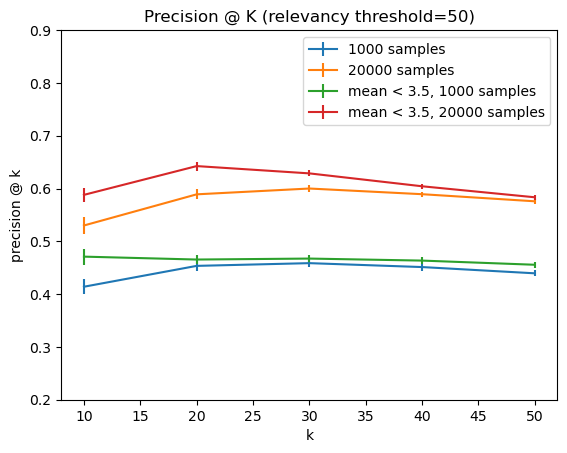

In [29]:
rater_condition=(df_train['number_ratings']>0)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'1000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['number_ratings']>0)
plot_precisions(df_items_200,df_train,rater_condition,20000,num_iterations,'20000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['pikiness']<3.5)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'mean < 3.5, 1000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['pikiness']<3.5)
plot_precisions(df_items_200,df_train,rater_condition,20000,num_iterations,'mean < 3.5, 20000 samples',top_x_threshold,relevant_threshold)
plt.xlabel('k')
plt.ylabel('precision @ k')
plt.legend(loc='upper right')
plt.ylim([0.2,0.9])
plt.title('Precision @ K (relevancy threshold='+str(relevant_threshold)+')')

Text(0.5, 1.0, 'Precision @ K (relevancy threshold=50)')

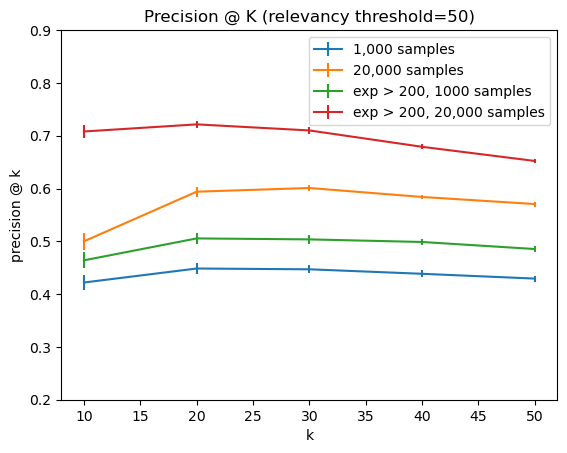

In [30]:
rater_condition=(df_train['number_ratings']>0)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'1,000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['number_ratings']>0)
plot_precisions(df_items_200,df_train,rater_condition,20000,num_iterations,'20,000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['exp']>200)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'exp > 200, 1000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['exp']>200)
plot_precisions(df_items_200,df_train,rater_condition,20000,num_iterations,'exp > 200, 20,000 samples',top_x_threshold,relevant_threshold)
plt.xlabel('k')
plt.ylabel('precision @ k')
plt.legend(loc='upper right')
plt.ylim([0.2,0.9])
plt.title('Precision @ K (relevancy threshold='+str(relevant_threshold)+')')

Text(0.5, 1.0, 'Precision @ K (relevancy threshold=50)')

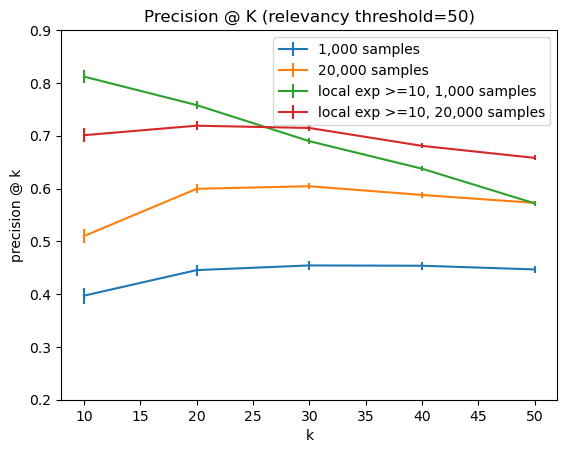

In [31]:
rater_condition=(df_train['number_ratings']>0)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'1,000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['number_ratings']>0)
plot_precisions(df_items_200,df_train,rater_condition,20000,num_iterations,'20,000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['number_ratings']>=10) 
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'local exp >=10, 1,000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['number_ratings']>=10)
plot_precisions(df_items_200,df_train,rater_condition,20000,num_iterations,'local exp >=10, 20,000 samples',top_x_threshold,relevant_threshold)
plt.xlabel('k')
plt.ylabel('precision @ k')
plt.legend(loc='upper right')
plt.ylim([0.2,0.9])
plt.title('Precision @ K (relevancy threshold='+str(relevant_threshold)+')')

Text(0.5, 1.0, 'Precision @ K (relevancy threshold=50)')

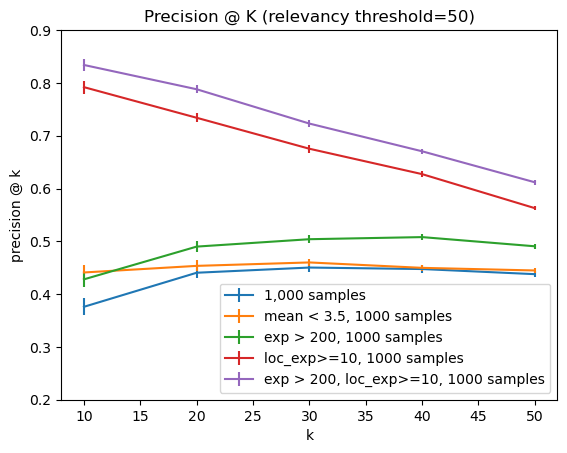

In [32]:
rater_condition=(df_train['number_ratings']>0)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'1,000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['pikiness']<3.5)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'mean < 3.5, 1000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['exp']>200)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'exp > 200, 1000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['number_ratings']>=10)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'loc_exp>=10, 1000 samples',top_x_threshold,relevant_threshold)
rater_condition=(df_train['exp']>200) & (df_train['number_ratings']>=10)
plot_precisions(df_items_200,df_train,rater_condition,1000,num_iterations,'exp > 200, loc_exp>=10, 1000 samples',top_x_threshold,relevant_threshold)
plt.xlabel('k')
plt.ylabel('precision @ k')
plt.legend(loc='lower right')
plt.ylim([0.2,0.9])
plt.title('Precision @ K (relevancy threshold='+str(relevant_threshold)+')')

# what are the best regions according to Qualified Regional Ratings?

In [33]:
# all raters
df_items_all=get_item_df(df)
top50_all_raters=df_items_all.sort_values(by='weighted_rating',ascending=False).head(50).index
top50_all_raters

Index(['californian-bordeaux-blend', 'bordeaux-left-bank-pauillac',
       'northern-rhone-cote-rotie', 'italian-amarone', 'italian-brunello',
       'bordeaux-left-bank-saint-julien', 'bordeaux-sauternes',
       'italian-bolgheri', 'bordeaux-left-bank-margaux', 'french-champagne',
       'spanish-pedro-ximenez', 'bordeaux-left-bank-pessac-leognan',
       'bordeaux-right-bank-pomerol', 'italian-barolo',
       'hungarian-bordeaux-blend', 'argentinian-cabernet-malbec',
       'south-african-cabernet-franc', 'bordeaux-left-bank-saint-estephe',
       'californian-cabernet-franc', 'northern-rhone-white',
       'portuguese-madeira', 'portuguese-port', 'italian-barbaresco',
       'spanish-priorat-red', 'burgundy-white', 'argentinian-bordeaux-blend',
       'english-sparkling', 'californian-cabernet-sauvignon',
       'loire-chenin-blanc', 'washington-state-syrah', 'jura-vin-jaune',
       'bordeaux-right-bank-saint-emilion', 'portuguese-moscatel',
       'burgundy-red', 'washington-stat

In [34]:
rater_condition= (df['number_ratings']>=10) 
df_items_condition=get_item_df(df[rater_condition])
top50_qualified_raters=df_items_condition.sort_values(by='weighted_rating',ascending=False).head(50)

In [35]:
df_filtered = top50_qualified_raters[~top50_qualified_raters.index.isin(top50_all_raters)]
df_filtered[['item_rating_count','weighted_rating']].iloc[0:10]

,item_rating_count,weighted_rating
item,,
greek-amyndeon-red,2,4.426087
spanish-rhone-blend,1,4.300000
australian-viognier,1,4.200000
israeli-syrah,2,4.175000
german-gewurztraminer,3,4.058537
swiss-syrah,2,4.026316
chilean-bordeaux-blend,94,3.965989
canadian-syrah,24,3.959631
new-zealand-chardonnay,29,3.918130
